/var/folders/90/0y2s7s2s13gg5ppzrhs4cb500000gn/T/ipykernel_97926/868459738.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)
[*********************100%***********************]  4 of 4 completed


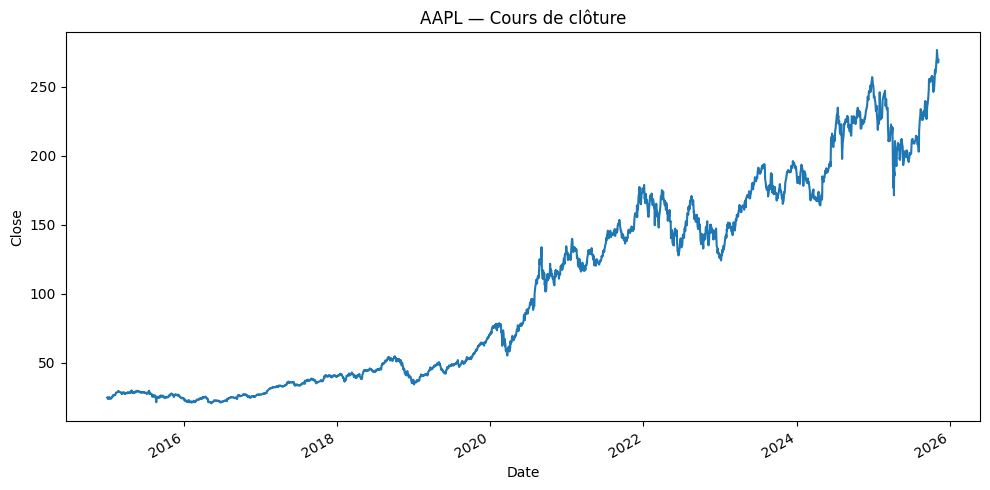

In [1]:
import yfinance as yf
import pandas as pd

# Liste des tickers à collecter
tickers = ["^GSPC", "^FCHI", "AAPL", "MSFT"]

# Définir la plage de temps (par exemple, 5 ans)
start_date = "2015-01-01"
end_date = "2025-11-10" # Date d'aujourd'hui ou récente

# Téléchargement des données
data = yf.download(tickers, start=start_date, end=end_date)

# Les données sont dans un DataFrame Pandas multi-niveaux.
# Pour l'analyse de série temporelle, vous vous concentrerez souvent sur la colonne 'Close' (prix de clôture).
prix_cloture_sp500 = data['Close']['^GSPC']

import matplotlib.pyplot as plt

# S'assurer que l'index est bien de type datetime et trié
data = data.copy()
data.index = pd.to_datetime(data.index)
data = data.sort_index()

# Extraire la série AAPL (Close)
aapl_close = data.loc[:, ('Open', 'AAPL')].dropna()

# Tracer
plt.figure(figsize=(10,5))
plt.plot(aapl_close.index, aapl_close.values)
plt.title("AAPL — Cours de clôture")
plt.xlabel("Date")
plt.ylabel("Close")
plt.gcf().autofmt_xdate()  # joli format de dates
plt.tight_layout()
plt.show()


In [2]:
import sys, yfinance as yf
print(sys.executable)   # doit pointer vers .../indexpulse/.venv/bin/python
print(yf.__version__)   # version installée

/Users/souhail/projets-ml/indexpulse/.venv/bin/python
0.2.66


In [3]:
TICKERS = ["^GSPC","^DJI","^IXIC","^FCHI","^GDAXI","^FTSE","^STOXX50E","^N225","^HSI","^KS11","^AXJO","^GSPTSE","^BVSP"]
df = yf.download(TICKERS, interval="1d", auto_adjust=True, group_by='ticker', progress=False)
# Empilement propre (Close uniquement)
close = pd.concat({t: df[t]["Close"] for t in TICKERS}, axis=1).sort_index()
close.columns = [c.replace("^","") for c in close.columns]  # colonnes propres
close.tail()

,GSPC,DJI,IXIC,FCHI,GDAXI,FTSE,STOXX50E,N225,HSI,KS11,AXJO,GSPTSE,BVSP
Date,,,,,,,,,,,,,
2025-11-06,6720.319824,46912.300781,23053.990234,7964.770020,23734.019531,9735.799805,5611.180176,50883.679688,26485.900391,4026.449951,8831.799805,29868.599609,153339.0
2025-11-07,6728.799805,46987.101562,23004.539062,7950.180176,23569.960938,9682.599609,5566.529785,50276.371094,26241.830078,3953.760010,8769.700195,29912.199219,154064.0
2025-11-10,6832.430176,47368.628906,23527.169922,8055.509766,23959.990234,9787.200195,5664.459961,50911.761719,26649.060547,4073.239990,8830.900391,30316.599609,155257.0
2025-11-11,6846.609863,47927.960938,23468.300781,8156.229980,24088.060547,9899.599609,5725.700195,50842.929688,26696.410156,4106.390137,8818.799805,30409.300781,157749.0
2025-11-12,NaN,NaN,NaN,8243.559570,24344.330078,9887.790039,5789.020020,51063.308594,26922.730469,4150.390137,8799.500000,NaN,NaN


In [5]:
import numpy as np
feat = close.copy()
ret = close.pct_change().add_suffix("_ret1")
logret = (close.pipe(lambda x: (x/x.shift(1)).apply(lambda s: (s).map(lambda v: None if pd.isna(v) else pd.np.log(v))))).add_suffix("_logret1")
sma20 = close.rolling(20).mean().add_suffix("_sma20")
vol20 = close.pct_change().rolling(20).std().add_suffix("_vol20")
X = pd.concat([ret, logret, sma20, vol20], axis=1).dropna()
X.tail()

/var/folders/90/0y2s7s2s13gg5ppzrhs4cb500000gn/T/ipykernel_97926/3329970507.py:3: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  ret = close.pct_change().add_suffix("_ret1")


AttributeError: module 'pandas' has no attribute 'np'

In [6]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def arima_forecast(series, order=(1,1,1), horizon=5):
    train = series.dropna()
    model = ARIMA(train, order=order).fit()
    fc = model.forecast(steps=horizon)
    return fc, model

y = close["GSPC"].dropna()  # S&P 500
fc, mdl = arima_forecast(y)
rmse = np.sqrt(mean_squared_error(y.tail(len(fc)), fc.reindex(y.tail(len(fc)).index, fill_value=np.nan).dropna()))
mae = mean_absolute_error(y.tail(len(fc)).dropna(), fc.reindex(y.tail(len(fc)).index, fill_value=np.nan).dropna())
rmse, mae


ValueError: Found input variables with inconsistent numbers of samples: [5, 0]